In [4]:
%matplotlib qt

## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


In [5]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [27]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

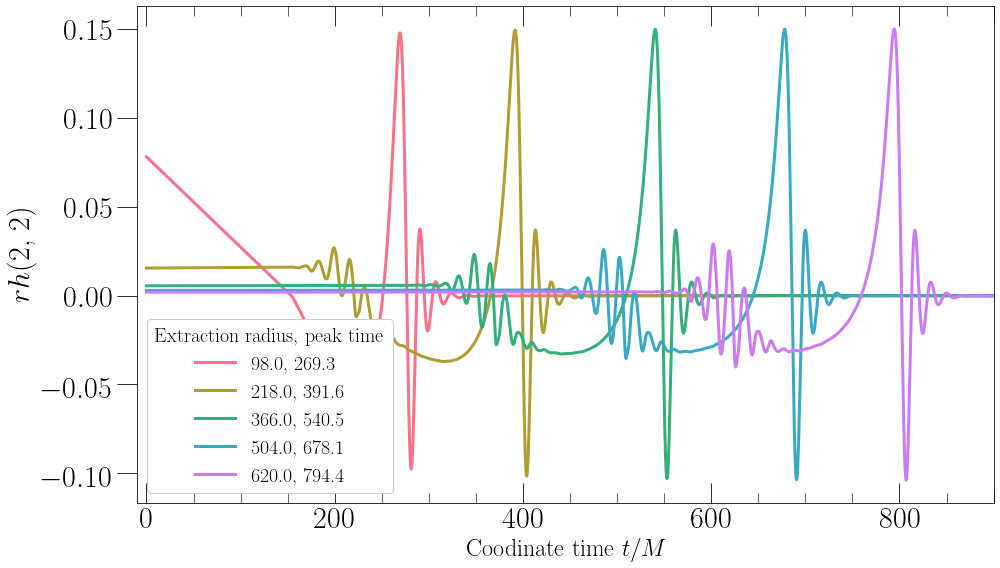

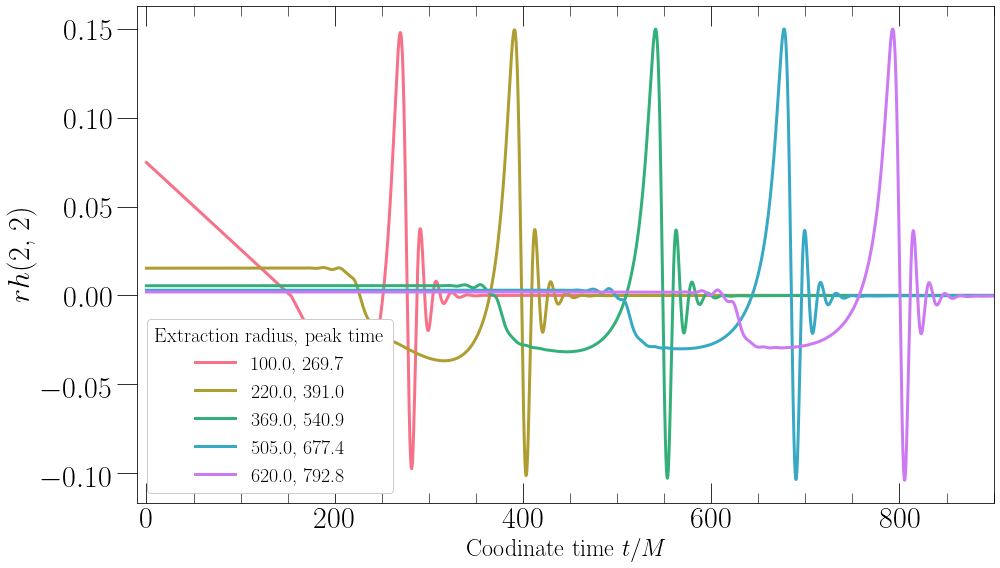

In [51]:
def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower left', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
PlotRadiiStrain('Data/HeadOn/JoinedLev1/')
PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev1/')

In [6]:
## Plot the vanilla SpEC lensing run results

def PlotRefinementMethodResult(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""
    
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_positions = data[:,1]
    y_positions = data[:,2]
    z_positions = data[:,3]
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(x_positions, y_positions, color='red')
    #plt.xlim(-5.0, 5.0)
    #plt.ylim(-5.0, 5.0)

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.savefig('Camera.pdf')
    plt.show()
    
#PlotRefinementMethodResult('Data/HeadOn/LensingData')
PlotRefinementMethodResult('Data/HeadOn_Harmonic/LensingData')

In [5]:
## Plot the vanilla SpEC lensing run results

def Plot3DFinalPositions(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""

    plt.rcParams['grid.linewidth'] = 0.25
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_pos = data[:,1]
    y_pos = data[:,2]
    z_pos = data[:,3]
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.scatter(x_pos, y_pos, z_pos, color='red', s=10)
    ax.scatter([0.0], [0.0], [100.0], color='black', s = 100)
    ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='black')
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    plt.tight_layout()
    plt.savefig('Positions.pdf')
    plt.show()
    
Plot3DFinalPositions('Data/HeadOn_Harmonic/LensingData')
